In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics.functional as metrics
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.datasets import fetch_openml
from typing import Union, List


In [2]:
class CModel(nn.Module):
    def __init__(self, in_: int, out_: int) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, out_),
        )

    def forward(self, x):
        x = self.layers(x)
        return x


In [3]:
class MulticlassDataset(Dataset):
    def __init__(
        self,
        X_data: Union[np.ndarray, pd.DataFrame],
        y_data: Union[np.ndarray, pd.DataFrame],
    ):
        super().__init__()
        try:
            X_data = X_data if isinstance(X_data, np.ndarray) else X_data.values
            y_data = y_data if isinstance(y_data, np.ndarray) else y_data.values
            X_data = (X_data / 255.0).astype(np.float32)
            y_data = y_data.astype(np.int64)
            self.feature = torch.tensor(X_data)
            self.target = torch.tensor(y_data)
        except Exception as e:
            print(e)

    def __len__(self):
        return self.target.shape[0]

    def __getitem__(self, idx: int):
        return self.feature[idx], self.target[idx]

    def getInOut(self):
        return self.feature.shape[1], len(torch.unique(self.target))


In [4]:
class MulticlassModel:
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    loss_fn = nn.CrossEntropyLoss().to(device)

    def __init__(
        self,
        X_data: Union[np.ndarray, pd.DataFrame],
        y_data: Union[np.ndarray, pd.DataFrame],
        split_size: List[Union[int, float]] = [0.8, 0.1, 0.1],
        seed: int = 42,
        epochs: int = 1000,
        batch: int = 32,
        optim_lr: float = 0.001,
        optim_eps: float = 1e-8,
        optim_weight_decay: float = 0,
        sch_mode: str = "min",
        sch_factor: float = 0.1,
        sch_patience: int = 10,
        sch_threshold: float = 1e-4,
        sch_min_lr: float = 0,
        auto_stop: bool = True,
        stop_count: int = 10,
        view_verbose: bool = False,
    ):
        self.dataset = MulticlassDataset(X_data, y_data)
        self.split_size = split_size
        self.seed = seed
        self.epochs = epochs
        self.batch = batch
        self.auto_stop = auto_stop
        self.stop_count = stop_count
        self.view_verbose = view_verbose

        self.in_, self.out_ = self.dataset.getInOut()
        self.model = CModel(self.in_, self.out_).to(MulticlassModel.device)
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=optim_lr,
            eps=optim_eps,
            weight_decay=optim_weight_decay,
        )
        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode=sch_mode,
            factor=sch_factor,
            patience=sch_patience,
            threshold=sch_threshold,
            min_lr=sch_min_lr,
            eps=optim_eps,
        )
        self.__split_dataset()

    def __split_dataset(self):
        seed = torch.manual_seed(self.seed)
        self.trainDS, self.validDS, self.testDS = random_split(
            self.dataset, self.split_size, generator=seed
        )
        self.trainDL = DataLoader(self.trainDS, batch_size=self.batch, drop_last=True)
        self.validDL = DataLoader(self.validDS, batch_size=self.batch, drop_last=True)
        self.testDL = DataLoader(self.testDS, batch_size=self.batch, drop_last=True)

    def print_dataset_info(self):
        print(f"batch size : {self.batch}")
        print(
            f"TrainDS: {len(self.trainDS)}개, ValidDS: {len(self.validDS)}개, TestDS : {len(self.testDS)}개"
        )
        print(
            f"TrainDL: {len(self.trainDL)}개, ValidDL: {len(self.validDL)}개, TestDL : {len(self.testDL)}개"
        )

    def training(self):
        self.model.train()

        lossList = []
        for feature, target in self.trainDL:
            feature, target = feature.to(MulticlassModel.device), target.to(
                MulticlassModel.device
            )
            pre_target = self.model(feature)
            loss = MulticlassModel.loss_fn(pre_target, target)
            lossList.append(loss.item())

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        loss = np.mean(lossList)
        acc = metrics.accuracy(
            pre_target, target, task="multiclass", num_classes=self.out_
        )
        return loss, acc.item()

    def testing(self, test_mode: bool = False):
        if test_mode:
            dataset = self.testDL
        else:
            dataset = self.validDL
        self.model.eval()

        with torch.no_grad():
            lossList = []
            for feature, target in dataset:
                feature, target = feature.to(MulticlassModel.device), target.to(
                    MulticlassModel.device
                )
                pre_target = self.model(feature)
                loss = MulticlassModel.loss_fn(pre_target, target)
                lossList.append(loss.item())
            loss = np.mean(lossList)
            acc = metrics.accuracy(
                pre_target, target, task="multiclass", num_classes=self.out_
            )
            return loss, acc.item()

    def fit(self):
        count = 0
        train_list = [[], []]
        val_list = [[], []]
        pre_val_acc = 0
        for epoch in range(self.epochs + 1):
            train_loss, train_acc = self.training()
            val_loss, val_acc = self.testing()
            train_list[0].append(train_loss), train_list[1].append(train_acc)
            val_list[0].append(val_loss), val_list[1].append(val_acc)
            self.scheduler.step(val_loss)

            if self.auto_stop:
                if pre_val_acc == val_acc:
                    count += 1
                    if count >= self.stop_count:
                        self.__print_result(
                            epoch, train_loss, train_acc, val_loss, val_acc, count
                        )
                        break
                else:
                    pre_val_acc = val_acc
                    count = 0

            if self.view_verbose:
                self.__print_result(
                    epoch, train_loss, train_acc, val_loss, val_acc, count
                )
        self.train_list = train_list
        self.val_list = val_list

    def get_train_lossList(self):
        return self.train_list[0]

    def get_train_accList(self):
        return self.train_list[1]

    def get_val_lossList(self):
        return self.val_list[0]

    def get_val_accList(self):
        return self.val_list[1]

    def predict(self, data):
        if not isinstance(data, torch.Tensor):
            data = torch.FloatTensor(data).to(self.device)
        self.model.eval()
        with torch.no_grad():
            result = self.model(data).argmax().item()
        return result

    def __print_result(self, epoch, train_loss, train_acc, val_loss, val_acc, count):
        bad_epochs = self.scheduler.num_bad_epochs
        print("=================================================")
        print(f" [Epoch {epoch:4d}/{self.epochs}]")
        print(
            f" [Bad epochs] {bad_epochs:2d}       [Same Accuracy] {count:2d}/{self.stop_count}"
        )
        print("-------------------------------------------------")
        print(f" [Train Loss] {train_loss:.6f} [Train Accuracy] {train_acc:.6f}")
        print(f" [Valid Loss] {val_loss:.6f} [Valid Accuracy] {val_acc:.6f}")


In [5]:
mnist_fashion = fetch_openml("Fashion-MNIST", parser="auto", as_frame=False)


In [6]:
X, y = mnist_fashion.data, mnist_fashion.target
X.shape, y.shape


((70000, 784), (70000,))

In [7]:
model = MulticlassModel(
    X,
    y,
    split_size=[50000, 10000, 10000],
    batch=64,
    optim_lr=0.001,
    optim_weight_decay=1e-3,
    sch_factor=0.2,
    sch_patience=5,
    sch_threshold=1e-3,
    sch_min_lr=1e-6,
    stop_count=10,
    view_verbose=True,
)


In [8]:
model.print_dataset_info()


batch size : 64
TrainDS: 50000개, ValidDS: 10000개, TestDS : 10000개
TrainDL: 781개, ValidDL: 156개, TestDL : 156개


In [9]:
model.fit()


 [Epoch    0/1000]
 [Bad epochs]  0       [Same Accuracy]  0/10
-------------------------------------------------
 [Train Loss] 0.576210 [Train Accuracy] 0.890625
 [Valid Loss] 0.453233 [Valid Accuracy] 0.812500
 [Epoch    1/1000]
 [Bad epochs]  0       [Same Accuracy]  0/10
-------------------------------------------------
 [Train Loss] 0.425484 [Train Accuracy] 0.875000
 [Valid Loss] 0.419657 [Valid Accuracy] 0.859375
 [Epoch    2/1000]
 [Bad epochs]  0       [Same Accuracy]  0/10
-------------------------------------------------
 [Train Loss] 0.393304 [Train Accuracy] 0.859375
 [Valid Loss] 0.412105 [Valid Accuracy] 0.843750
 [Epoch    3/1000]
 [Bad epochs]  0       [Same Accuracy]  0/10
-------------------------------------------------
 [Train Loss] 0.372892 [Train Accuracy] 0.859375
 [Valid Loss] 0.393114 [Valid Accuracy] 0.875000
 [Epoch    4/1000]
 [Bad epochs]  0       [Same Accuracy]  0/10
-------------------------------------------------
 [Train Loss] 0.358675 [Train Accuracy

In [10]:
model.testing(test_mode=True)


(0.3060806102286547, 0.890625)

In [24]:
for i in np.random.choice(70000, 20):
    print(
        f"{i:5d}번 샘플 - 예측 : {model.predict(X[i])} 정답 : {y[i]} => {model.predict(X[i]) == int(y[i])}"
    )


46759번 샘플 - 예측 : 5 정답 : 5 => True
64586번 샘플 - 예측 : 8 정답 : 8 => True
15652번 샘플 - 예측 : 3 정답 : 3 => True
53097번 샘플 - 예측 : 1 정답 : 1 => True
31819번 샘플 - 예측 : 4 정답 : 4 => True
23421번 샘플 - 예측 : 8 정답 : 8 => True
56758번 샘플 - 예측 : 7 정답 : 7 => True
41110번 샘플 - 예측 : 5 정답 : 5 => True
45865번 샘플 - 예측 : 4 정답 : 4 => True
51686번 샘플 - 예측 : 4 정답 : 2 => False
46864번 샘플 - 예측 : 4 정답 : 4 => True
67022번 샘플 - 예측 : 0 정답 : 0 => True
29528번 샘플 - 예측 : 9 정답 : 7 => False
18597번 샘플 - 예측 : 2 정답 : 2 => True
69397번 샘플 - 예측 : 4 정답 : 2 => False
47171번 샘플 - 예측 : 3 정답 : 3 => True
31280번 샘플 - 예측 : 4 정답 : 3 => False
20936번 샘플 - 예측 : 8 정답 : 8 => True
22462번 샘플 - 예측 : 0 정답 : 0 => True
56707번 샘플 - 예측 : 6 정답 : 6 => True


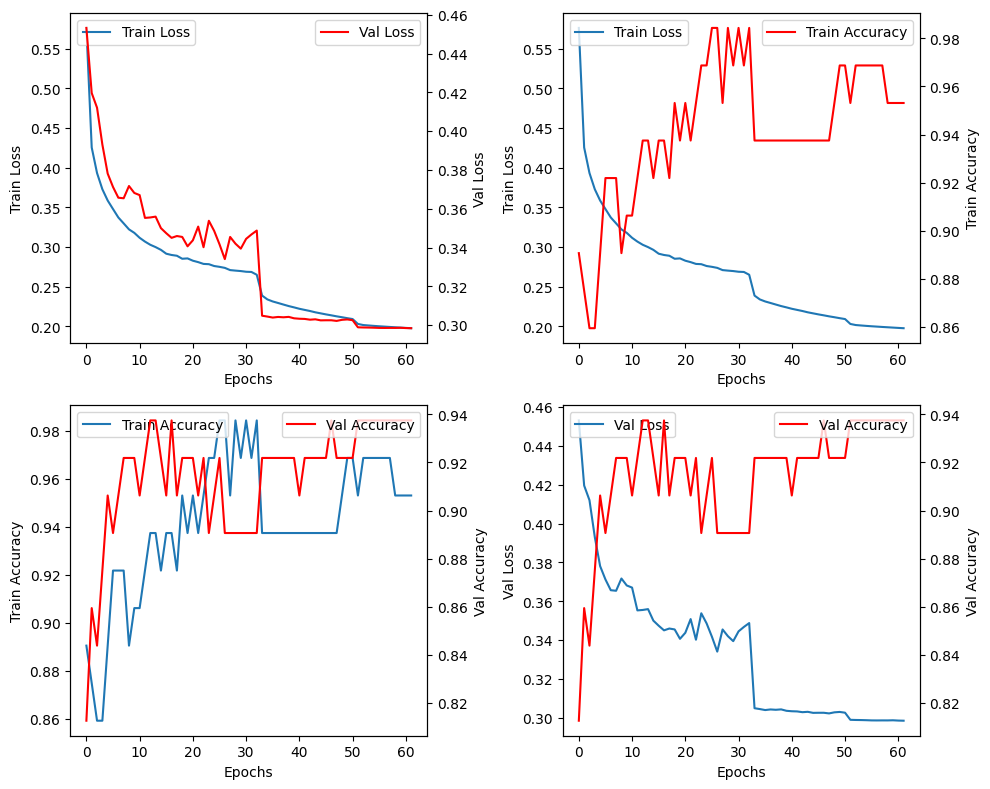

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].plot(model.get_train_lossList(), label="Train Loss")
axs[0, 0].legend(loc="upper left")
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].set_ylabel("Train Loss")
axs1 = axs[0, 0].twinx()
axs1.plot(model.get_val_lossList(), label="Val Loss", color="red")
axs1.legend(loc="upper right")
axs1.set_ylabel("Val Loss")

axs[0, 1].plot(model.get_train_lossList(), label="Train Loss")
axs[0, 1].legend(loc="upper left")
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].set_ylabel("Train Loss")
axs2 = axs[0, 1].twinx()
axs2.plot(model.get_train_accList(), label="Train Accuracy", color="red")
axs2.legend(loc="upper right")
axs2.set_ylabel("Train Accuracy")


axs[1, 0].plot(model.get_train_accList(), label="Train Accuracy")
axs[1, 0].legend(loc="upper left")
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Train Accuracy")
axs3 = axs[1, 0].twinx()
axs3.plot(model.get_val_accList(), label="Val Accuracy", color="red")
axs3.legend(loc="upper right")
axs3.set_ylabel("Val Accuracy")


axs[1, 1].plot(model.get_val_lossList(), label="Val Loss")
axs[1, 1].legend(loc="upper left")
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Val Loss")
axs4 = axs[1, 1].twinx()
axs4.plot(model.get_val_accList(), label="Val Accuracy", color="red")
axs4.legend(loc="upper right")
axs4.set_ylabel("Val Accuracy")
plt.tight_layout()
plt.show()
